# Análisis de distribución de casos + de Madrid

Cambios para  trabajar con la version de 4 paginas

## Objetivo

El procedimiento de comunicación de datos positivos de Covid de la Comunidad de Madrid se basa en comunicar un número total diarios, primera página de este pdf por ejemplo, mencionándose, a continuación, los que corresponden al día anterior. El resto se distribuyen entre días pasados. Nos preguntamos como se hace ese reparto, hasta cuando se "reparten" esos positivos, ¿cuánto hacia atrás se están llevando?, qué equivale a decir: con qué retraso se están asignando esos casos, de hoy por ejemplo, a sus fechas reales?.
En este trabajo vamos a intentar responder a esa pregunta

## Pasos a seguir

1. Partimos de un fichero csv en el que, con formato tabla ya disponemos de los datos de dias anteriores. Bajaremos y trabajaremos solo sobre los últimos ficheros no incorporados. 
2. Leeremos esos ficheros buscando las tablas de acumulado, que aparecen en la página 2 y 3 de ese documento. Y los incorporaremos al csv histórico,
3. Construiremos, con esa información, la "visión" de casos que se ha tenido en cada uno de los días desde Septiembre, guardándolas como columnas de un `pandas`
4. A continuación calcularemos los incrementales diarios de cada día, es decir los positivos comunicados en el documento de un día en concreto: a qué días se están asignando.
5. En este punto tendremos un `pandas`con los datos de cada día de publicación en columna, y cada fila representa el día al que se asocia.
6. Por último desplazaremos cada columna para que cada fila represente de manera relativa días de diferencia con el de publicación (así hablaremos de que un dato presentado en día `t` se ha asignado a un día `t-3` por ejemplo, tres días anteriores.
7. Finalmente preparemos un gráfico para visualizar este comportamiento.

Para los pasos 1 y 2 he utilizado el script escrito por [@alfonsotwr](https://twitter.com/alfonsotwr) , disponible en su [github](https://github.com/alfonsotwr/snippets/tree/master/covidia-cam). Todo el código de esos pasos es suyo. 
Manos a la obra

## Código

Tenemos un montón de librerias con las que vamos a trabajar, no he tenido ningún problema en instalar aquellas no disponibles en el entorno Anaconda con el que trabajo por medio de `pip install libreria` realizado desde un terminal abierto desde el entorno `env`.

In [2]:
import os.path as pth
import datetime as dt
import time
from glob import glob
import re
import pandas as pd
import numpy as np

import requests
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
from datetime import datetime
import seaborn as sns
%matplotlib inline

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO

Preparamos las expresiones regulares que nos ayudarán en la interpretación de la información que sacamos de los pdf.

In [3]:
expnumber = re.compile(r'^ *(\d+(?: ?\. ?\d+)*)(?:[^\d/]|\s|\(|$|\.[^\d/]|\.\s|\.$)', re.M)
expfecha = re.compile(r'(\d\d)/(\d\d)/(\d\d\d\d)') #fechas
#añadido 12 desde 30/11
expacum = re.compile(r'\n2 \n7 \n12 \n[\d \n]+') #acumulados, 2,7,11 son los primeros datos de la serie
expnumber2 = re.compile(r'\d\d\d\d\d+')

Definimos variables que nos ayuden en la gestión de los nombres de los ficheros.

In [4]:
URL_TPL = 'https://www.comunidad.madrid/sites/default/files/doc/sanidad/{:02d}{:02d}{:02d}_cam_covid19.pdf'
FN_TPL = '{:02d}{:02d}{:02d}_cam_covid19.pdf'
FN_TPL_txt = '{:02d}{:02d}{:02d}_cam_covid19.txt'
datadir='data/'
fichero_csv='numeros_madrid_tabla.csv'
csvdir='csv/'

Función que descarga el fichero pdf solicitado

In [5]:
ALWAYS_UPDATE = True
def descarga(url, fn, isbinary=False, isascii=False, isbackup=False,
             prevpage=None):
    #función para descargar el fichero depositado en url y que guardamos con 
    #nombre fn
    
    
    today = dt.date.today()

    ret = True

    if pth.isfile(fn):
        modifiedTime = pth.getmtime(fn)
        changed = dt.datetime.fromtimestamp(modifiedTime).date()

        if isbackup:
            basename = pth.basename(fn)
            rootfn, ext = pth.splitext(basename)
            dirname = pth.dirname(fn)
            changedstr = str(changed)

            backupfn = pth.join(dirname, 'backup',
                                rootfn + '-' + changedstr + ext)
            print('Backup: {} -> {}'.format(fn, backupfn))
            copyfile(fn, backupfn)


    if not pth.isfile(fn) or changed != today or ALWAYS_UPDATE:
        print('Descargando:', url)
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
        with requests.Session() as s:
            if prevpage:
                s.get(prevpage, headers=headers)
            r = s.get(url, headers=headers)
        if r.status_code == requests.codes.ok:
            if isbinary:
                with open(fn, 'wb') as fp:
                    fp.write(r.content)
            elif isascii:
                content = r.content
                text = r.content.decode('ascii', 'ignore')
                with open(fn, 'w', encoding='utf-8') as fp:
                    fp.write(text)
            else:
                with open(fn, 'w', encoding='utf-8') as fp:
                    fp.write(r.text)
        else:
            print('ERROR', r.status_code, 'descargando:', fn)
            ret = False

    return ret

Funcion que extrae el texto del pdf en cuestión, pudiendo seleccionar una página

In [6]:
# Extract PDF text using PDFMiner. Adapted from
# http://stackoverflow.com/questions/5725278/python-help-using-pdfminer-as-a-library

def pdf_to_text(pdfname, pagenum=None):

    # PDFMiner boilerplate
    rsrcmgr = PDFResourceManager()
    sio = StringIO()
    laparams = LAParams()
    device = None
    try:
        device = TextConverter(rsrcmgr, sio, laparams=laparams)
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        # Extract text
        with open(pdfname, 'rb') as fp:
            for i, page in enumerate(PDFPage.get_pages(fp)):
                if pagenum is None or pagenum == i:
                    interpreter.process_page(page)

        # Get text from StringIO
        text = sio.getvalue()
    finally:
        # Cleanup
        sio.close()
        if device is not None:
            device.close()

    return text

Seleccionamos los días de los que nos queremos bajar la información:

In [7]:
today = dt.date.today()
un_dia = dt.timedelta(days=1)
tomorrow = today+un_dia
desde = dt.date(year=2020,month=9,day=1)

In [8]:
# descargamos los ficheros pdf necesarios
# sacado del script de @alfonsotwr mencionado

date_array_download = np.arange(today, tomorrow,
                                    np.timedelta64(1,'D'), dtype='datetime64')

for dia in date_array_download:
    pdfdir = 'data/'
    dia_dt = dia.item()
    #if dia_dt.weekday() in [5,6]:
    #    continue
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    url = URL_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    ret = descarga(url, fn, isbinary=True)
    time.sleep(1)
    if not ret:
        changed = False
        if dia_dt == dt.date(2020, 9, 2):  # special cases
                url = url.replace('/doc/sanidad', '')
                changed = True
        if changed:
            descarga(url, fn, isbinary=True)
            time.sleep(1)

Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/201222_cam_covid19.pdf


In [10]:
#Creamos los txt con los datos
#basado en el script de @alfonsotwr mencionado
date_array=date_array_download

for dia in date_array:
    dia_dt = dia.item()
    #if (dia_dt.weekday() in [5,6]) or (dia_dt.month ==10 and dia_dt.day == 12):
    #    continue
    
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    #print(fn)
    fn1 = fn.replace('.pdf', '_1.txt')
    fn2 = fn.replace('.pdf', '_2.txt')
    fn3 = fn.replace('.pdf', '_3.txt')
    fn4 = fn.replace('.pdf', '_4.txt')
    
    #datos de la primera página del pdf
    print('Creating:', fn1)
    page1 = pdf_to_text(fn, pagenum=0)
    #with open(fn1, 'w', encoding='utf-8') as fp:
    with open(fn1, 'w') as fp:    
        fp.write(page1)
    
    #datos de la segunda página del pdf
    print('Creating:', fn2)
    page2 = pdf_to_text(fn, pagenum=1)
    #with open(fn2, 'w', encoding='utf-8') as fp:
    with open(fn2, 'w') as fp:     
        fp.write(page2)
    
    #datos de la tercera página del pdf
    print('Creating:', fn3)
    page3 = pdf_to_text(fn, pagenum=2)
    #with open(fn3, 'w', encoding='utf-8') as fp:
    with open(fn3, 'w') as fp:
        fp.write(page3)
        
        
    print('Creating:', fn4)
    page4 = pdf_to_text(fn, pagenum=3)
    #with open(fn3, 'w', encoding='utf-8') as fp:
    with open(fn4, 'w') as fp:
        fp.write(page4)

Creating: data/201222_cam_covid19_1.txt
Creating: data/201222_cam_covid19_2.txt
Creating: data/201222_cam_covid19_3.txt
Creating: data/201222_cam_covid19_4.txt


In [11]:
#creamos los ficheros csv a partir de los ficheros txt creados antes.
#basado en el script de @alfonsotwr mencionado

#csvfn = datadir + 'madrid-series.csv'


for dia in date_array:
    df = pd.DataFrame()
    pdfdir = 'data/'
    dia_dt = dia.item()
    # 30/11 quitamos la if dia_dt.weekday() in []
    if dia_dt.weekday() in []  or (dia_dt.month ==10 and dia_dt.day == 12):
        continue
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    #print(fn)
    fn2 = fn.replace('.pdf', '_2.txt')
    fn3 = fn2.replace('_2.txt', '_3.txt')
    print(fn2)
    #with open(fn2, encoding='utf-8') as fp:
    with open(fn2) as fp:
        text = fp.read()

    m = expacum.search(text)

    assert m, 'Debe ajustarse expacum con los primeros valores'

    accum = [int(x) for x in m.group().split()]

    dates = []
    for m in expfecha.finditer(text):
        dates.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                    int(m.group(1))))

    #accum2 = [int(x.group()) for x in expnumber2.finditer(text)
    #        if int(x.group()) > accum[-1]]
    #añadido para 2 noviembre
    dates = sorted(dates)
    
    accum2 = sorted(int(x.group()) for x in expnumber2.finditer(text)
                     if int(x.group()) > accum[-1])
    accum += accum2

    assert len(accum) == len(dates), 'La serie acumulada no concuerda para _2'

    print(fn3)
    #with open(fn3, encoding='utf-8') as fp:
    with open(fn3) as fp:   
        text = fp.read()

    dates2 = []
    for m in expfecha.finditer(text):
        dates2.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                      int(m.group(1))))
    dates += sorted(dates2)

    accum2 = [int(x.group()) for x in expnumber2.finditer(text)]
    
    accum += sorted(accum2)

    # assert len(accum) == len(dates), 'La serie acumulada no concuerda para _3'

    
    #añadido 22/12
    print(fn4)
    with open(fn4, encoding='utf-8') as fp:
        text = fp.read()

    dates2 = []
    for m in expfecha.finditer(text):
        dates2.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                       int(m.group(1))))
        
    dates += sorted(dates2)

    accum2 = [int(x.group()) for x in expnumber2.finditer(text)]
    accum += sorted(accum2)
    assert len(accum) == len(dates), 'La serie acumulada no concuerda para _4'  # noqa: E501
    
    #hasta aqui
    
    
    
    sr = pd.Series(accum, index=dates).sort_index()
    sr.name = 'PCR+'
    sr.index.name = 'Fecha'
    df2 = sr.to_frame()

    #if df.index[-1] != df2.index[-1] + dt.timedelta(1):
    #    raise RuntimeError('Última fecha de las tablas no coincide')

    # pd.set_option('display.max_rows', None)
    # print(sr)
    # print(sr.diff())
    assert all(sr.diff().dropna() >= 0), 'La serie acumulada no es creciente'
    assert all((sr.index[1:] - sr.index[:-1]).days > 0), 'Fechas no suben'

    csvfn = datadir + 'madrid_pcr_' + dia.item().strftime('_%d_%m')+'.csv'
    print('Escribiendo', csvfn)
    df2.to_csv(csvfn, line_terminator='\r\n')

data/201222_cam_covid19_2.txt
data/201222_cam_covid19_3.txt
data/201222_cam_covid19_4.txt
Escribiendo data/madrid_pcr__22_12.csv


A continuación vamos a generar el pandas con todas la información que hemos conseguido de los ficheros pdf

primero descargamos del directorio local la tabla con los valores históricos

In [12]:
df_hist=pd.read_csv(csvdir+fichero_csv,parse_dates=['fecha_publicacion','fecha_asignacion'])

vamos a crear ahora el pandas con los nuevos días a incorporar:

In [13]:
#df_hist=df_hist.loc[df_hist['fecha_publicacion']<datetime(year=2020,month=12,day=3)]

Si no hemos bajado ningun fichero nuevo no es necesario ejecutar este código:

In [14]:

df=pd.DataFrame() #creamos un pandas vacío para trabajar
date_array = np.arange(today, tomorrow,
                                    np.timedelta64(1,'D'), dtype='datetime64')

for dia in date_array[::-1]: #iteramos sobre todo el tiempo de análisis, desde 1 Sept
    dia_dt = dia.item() # date_array es un array de tiempo de numpy, con item() pasamos a datetime
    #quitamos la if dia_dt.weekday() in []
    #construimos el nombre del ficher csv en el que hemos guardado la info.
    nombre_csv=datadir+'madrid_pcr__{:02d}_{:02d}.csv'.format(dia_dt.day,dia_dt.month)
    
    #leemos el csv en un pandas df1
    df1=pd.read_csv(nombre_csv).set_index('Fecha')
    #asigbamos como nombre de columna el día en el que se publica (dia)
    nombre_columna='{:02d}-{:02d}-{:02d}'.format(dia_dt.year,dia_dt.month,dia_dt.day)
    df1.columns=[nombre_columna]
    
    #concatenamos es pandas recién leído con el principal
    df = pd.concat([df,df1], axis=1)
#invertimos el orden de las columnas para tener a la izquierda la fecha más antigua
df = df[df.columns[::-1]]

#Guardamos los pandas en el directorio local, en bruto, tal como salen del pdf, 
#sin calculo diferencias



In [15]:
df

,2020-12-22
Fecha,
2020-02-25,2
2020-02-26,7
2020-02-27,12
2020-02-28,25
2020-02-29,36
...,...
2020-12-17,387323
2020-12-18,388706
2020-12-19,389039


Ni este...

In [16]:
df=df.unstack().reset_index()
df.columns=['fecha_publicacion','fecha_asignacion','positivos']
df['fecha_publicacion']=pd.to_datetime(df['fecha_publicacion'])
df['fecha_asignacion']=pd.to_datetime(df['fecha_asignacion'])

Ni este, puesto que no hay que actualizar `df_hist`...

In [17]:
df_hist = pd.concat([df_hist,df])

In [71]:
df_hist

,fecha_publicacion,fecha_asignacion,positivos
0,2020-09-01,2020-02-25,2.0
1,2020-09-01,2020-02-26,7.0
2,2020-09-01,2020-02-27,11.0
3,2020-09-01,2020-02-28,22.0
4,2020-09-01,2020-02-29,29.0
...,...,...,...
296,2020-12-22,2020-12-17,387323.0
297,2020-12-22,2020-12-18,388706.0
298,2020-12-22,2020-12-19,389039.0
299,2020-12-22,2020-12-20,389273.0


In [19]:
df=df_hist.pivot(columns='fecha_publicacion',index='fecha_asignacion',values='positivos')

In [20]:
df_hist.iloc[-5:,-10:]

,fecha_publicacion,fecha_asignacion,positivos
296,2020-12-22,2020-12-17,387323.0
297,2020-12-22,2020-12-18,388706.0
298,2020-12-22,2020-12-19,389039.0
299,2020-12-22,2020-12-20,389273.0
300,2020-12-22,2020-12-21,390242.0


Guardamos en local los csv con los valores calculados.
Añadimos un formato en "tabbla": en cada fila `fecha_publicacion`, `fecha_asignacin`y `valor`

In [73]:
df.to_csv('csv/numeros_madrid.csv')
df.to_csv('csv/numeros_madrid'+today.strftime('%d-%m_%Y')+'.csv')
df_hist.columns=['fecha_publicacion','fecha_asignacion','positivos']
df_hist.to_csv('csv/numeros_madrid_tabla.csv',index=None)
df_hist.to_csv('csv/numeros_madrid_tabla'+today.strftime('%d-%m_%Y')+'.csv')

Calculamos ahora las diferencias de cada fila respecto a la anterior en tiempo, ya que hemos leído datos acumulados:.


In [21]:
df = df.diff()
df.fillna(0,inplace=True)
df = df.diff(axis=1)

In [22]:
df.tail(35)

fecha_publicacion,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22
fecha_asignacion,,,,,,,,,,,,,,,,,,,,,
2020-11-17,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,5.0,3.0,3.0,11.0,4.0,3.0,0.0,6.0
2020-11-18,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,6.0,10.0,3.0,8.0,3.0,0.0,2.0
2020-11-19,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3.0,4.0,6.0,12.0,7.0,12.0,4.0,3.0,7.0
2020-11-20,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,9.0,7.0,11.0,7.0,1.0,4.0,9.0
2020-11-21,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,2.0,4.0,1.0,0.0,1.0,0.0,3.0
2020-11-22,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,0.0,2.0
2020-11-23,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,8.0,9.0,2.0,6.0,3.0,4.0,1.0,4.0
2020-11-24,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,5.0,2.0,5.0,6.0,3.0,4.0,1.0,0.0
2020-11-25,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,6.0,4.0,7.0,2.0,7.0,2.0,2.0,2.0


Hagamos comprobaciones para asegurar que los datos son correctos: 

La suma de la columna del `2020-10-01`nos ha de dar el total de casos reportados ese día. Y efectivamente podemos chequear ese resultados [aquí](https://www.comunidad.madrid/sites/default/files/doc/sanidad/201002_cam_covid19.pdf): 4322

In [23]:
df['2020-10-01'].sum()

4342.0

Lo mismo con el día [02/09](https://www.comunidad.madrid/sites/default/files/200902_cam_covid19.pdf). Resultado también correcto 2617:

In [24]:
df['2020-09-02'].sum()

2617.0

Y de igual manera podemos ver que la suma de la fila correspondiente al día 5 de Septiembre:

In [25]:
df.loc['2020-09-05'].sum()

1672.0

coincide con el número de casos asignados a ese día en la tabla más actualizada, la del día [02/10](https://www.comunidad.madrid/sites/default/files/doc/sanidad/201002_cam_covid19.pdf)

Hagamos una parada para interpretar los datos que hemos conseguido. Esta es una imagen del `pandas`:

In [26]:
pd.set_option('display.max_columns', None) #para ver todas las columnas en pantalla
df.tail(30)

fecha_publicacion,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28,2020-11-29,2020-11-30,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22
fecha_asignacion,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-22,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,25.0,28.0,9.0,2.0,5.0,3.0,0.0,1.0,4.0,2.0,1.0,5.0,0.0,0.0,0.0,1.0,2.0,1.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,0.0,2.0
2020-11-23,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,603.0,73.0,80.0,61.0,34.0,6.0,0.0,32.0,23.0,11.0,7.0,4.0,2.0,0.0,1.0,1.0,6.0,6.0,4.0,0.0,1.0,8.0,9.0,2.0,6.0,3.0,4.0,1.0,4.0
2020-11-24,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,590.0,136.0,98.0,50.0,15.0,1.0,36.0,17.0,10.0,14.0,8.0,0.0,1.0,3.0,1.0,4.0,7.0,6.0,3.0,1.0,5.0,2.0,5.0,6.0,3.0,4.0,1.0,0.0
2020-11-25,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,622.0,109.0,84.0,17.0,4.0,40.0,17.0,22.0,23.0,21.0,5.0,1.0,1.0,1.0,5.0,7.0,6.0,4.0,4.0,6.0,4.0,7.0,2.0,7.0,2.0,2.0,2.0
2020-11-26,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,602.0,93.0,20.0,5.0,74.0,36.0,23.0,20.0,19.0,6.0,1.0,1.0,1.0,5.0,5.0,2.0,1.0,2.0,10.0,6.0,9.0,5.0,4.0,1.0,1.0,1.0
2020-11-27,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,657.0,152.0,9.0,93.0,44.0,30.0,18.0,20.0,4.0,2.0,1.0,4.0,13.0,10.0,7.0,2.0,3.0,12.0,6.0,5.0,3.0,1.0,4.0,0.0,6.0
2020-11-28,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,29.0,50.0,17.0,11.0,7.0,5.0,1.0,0.0,2.0,1.0,2.0,1.0,5.0,0.0,0.0,6.0,4.0,1.0,1.0,5.

**¿qué significa lo que vemos?**:
1. En el eje `x`podemos observar los días de publicación 
2. En el eje `y`podemos observar los días a los que se asigna los datos publicados el día expresado en `x`. De esa manera vemos por ejemplo que en la columna del día 22/09 (recordemos: datos publicados ese día) fila `2020-09-17`tenemos 440 casos. Es decir: del total de resultados publicados el día 22/09 440 se asignan al día 17 de Septiembre
3. Obviamente la esquina inferior izquierda está a cero corresponde a fechas posteriores a la publicación.

Nos queda el último paso: desplacemos las columnas hacía abajo para que en cada fila tengamos siempre los mismos días hacia atrás con respecto a cualquier columna. 

In [27]:
df1 = df.copy()

In [28]:
#tenemos que bajar tantos días como estemos alejados del último día
ref= df.columns[0]
rango = (df.columns[-1]-ref).days
for orden,columna in enumerate(df1.columns):
    desplazamiento = rango-(columna-ref).days
    df1[columna] = df1[columna].shift(periods=desplazamiento)
    print (columna,desplazamiento)
df1.index = np.arange(-len(df1.index),0) #cambiamos el nombre al índice para que nos indique, quitado el +1
#el número de días hacia atrás. Ahora cada celda en la fila no se refiere al mismo día, sino 
#al mismo "desplazamiento de días"

2020-09-01 00:00:00 112
2020-09-02 00:00:00 111
2020-09-03 00:00:00 110
2020-09-04 00:00:00 109
2020-09-07 00:00:00 106
2020-09-08 00:00:00 105
2020-09-09 00:00:00 104
2020-09-10 00:00:00 103
2020-09-11 00:00:00 102
2020-09-14 00:00:00 99
2020-09-15 00:00:00 98
2020-09-16 00:00:00 97
2020-09-17 00:00:00 96
2020-09-18 00:00:00 95
2020-09-21 00:00:00 92
2020-09-22 00:00:00 91
2020-09-23 00:00:00 90
2020-09-24 00:00:00 89
2020-09-25 00:00:00 88
2020-09-28 00:00:00 85
2020-09-29 00:00:00 84
2020-09-30 00:00:00 83
2020-10-01 00:00:00 82
2020-10-02 00:00:00 81
2020-10-05 00:00:00 78
2020-10-06 00:00:00 77
2020-10-07 00:00:00 76
2020-10-08 00:00:00 75
2020-10-09 00:00:00 74
2020-10-13 00:00:00 70
2020-10-14 00:00:00 69
2020-10-15 00:00:00 68
2020-10-16 00:00:00 67
2020-10-19 00:00:00 64
2020-10-20 00:00:00 63
2020-10-21 00:00:00 62
2020-10-22 00:00:00 61
2020-10-23 00:00:00 60
2020-10-26 00:00:00 57
2020-10-27 00:00:00 56
2020-10-28 00:00:00 55
2020-10-29 00:00:00 54
2020-10-30 00:00:00 53
20

Se ve mejor mostrando el `pandas`resultado por pantalla

In [29]:
df1.iloc[-5:,-10:]

fecha_publicacion,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22
-5,4.0,10.0,123.0,115.0,27.0,15.0,54.0,20.0,8.0,90.0
-4,24.0,15.0,110.0,70.0,20.0,62.0,87.0,28.0,15.0,134.0
-3,42.0,101.0,45.0,70.0,157.0,190.0,143.0,67.0,51.0,105.0
-2,147.0,36.0,25.0,133.0,214.0,210.0,162.0,256.0,35.0,69.0
-1,171.0,152.0,826.0,930.0,939.0,924.0,942.0,193.0,165.0,969.0


**Expliquemos los que estamos viendo**:
1. En el eje `x` seguimos viendo los días de publicación 
2. En el eje `y` podemos observar los días de desplazamiento a los que se asigna los datos publicados el día expresado en `x`. De esa manera vemos, por ejemplo, que en la columna del día 10/09 (recordemos: datos publicados ese día) fila **-7** tenemos **8**  casos. Es decir: del total de resultados publicados el día 10/09 se asignan **8** de ellos al día correspondiente a 7 días anteriores al día 10/09.


# Empezamos con la construcción de gráficos:

Ahora estamos en disposición de ver como se están asignando los casos de un determinado día en el pasado. 

He hecho varias pruebas con diferentes tipos de gráfico y creo que el mejor resultado se consigue con un mapa de calor. En particular voy a usar el `heatmap`de `seaborn`.


Por la irregular distribucón de los casos en los días he dado más granularidad a los valores bajos (por debajo de 300).

In [30]:
#preparación de la paleta de colores, dando más granularidad a los valores bajos
# 10 rangos entre 0 y 300, y 3 entre 300 y 3000.
rango_valores_1 = np.arange(0,300,30)
rango_valores_2 = np.arange(300,3000,900)
rango_valores = np.concatenate([rango_valores_1,rango_valores_2])
colores = sns.color_palette("magma_r",len(rango_valores)+1)
cmap, norm = colors.from_levels_and_colors(
    rango_valores, 
    colores,extend = 'both')

muchos problemas para formatear el eje x e y correctamente, hay que estudiar esta solución:
https://stackoverflow.com/questions/45345177/show-dates-on-seaborn-heatmap?rq=1

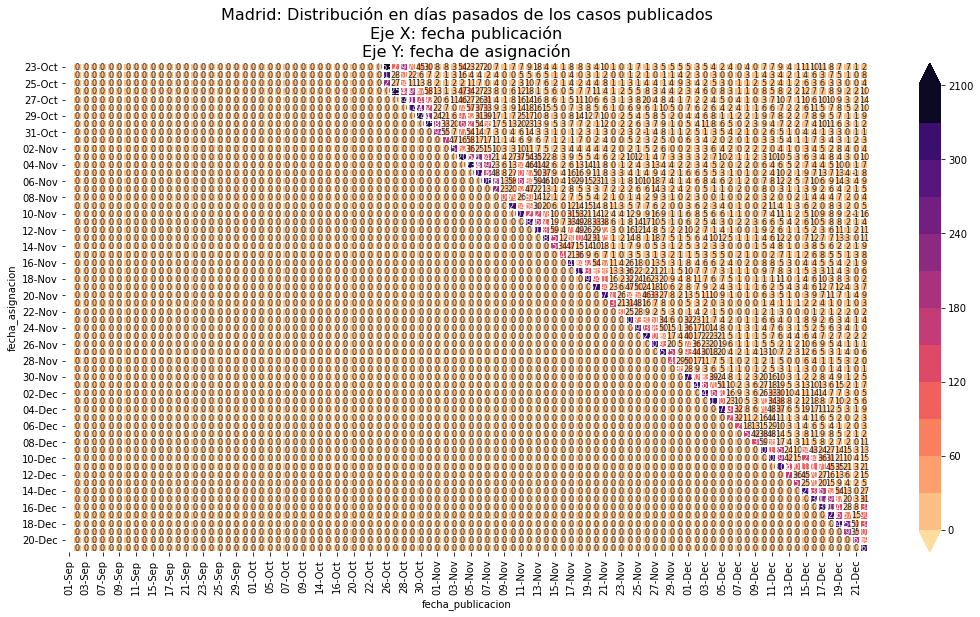

In [31]:
f, ax = plt.subplots(figsize=(18, 9))
sns.heatmap(df.loc[df.index[-60:],], annot=True, cmap=cmap,fmt='0.0f',norm=norm,linewidths=1, 
            ax=ax,annot_kws={"fontsize":8},xticklabels='auto')
#ax.xaxis.set_major_locator(WeekdayLocator([0,4]))
ax.set_xticklabels(datetime.strptime(i.get_text()[:10],'%Y-%m-%d').strftime('%d-%b') for i in ax.get_xticklabels())
ax.set_yticklabels(datetime.strptime(i.get_text()[:10],'%Y-%m-%d').strftime('%d-%b') for i in ax.get_yticklabels())
#XmajorFmt = DateFormatter('%-d-%b')
#majorFtm = 1
#ax.get_xticklabels()
#ax.xaxis.set_major_formatter('%')

ax.set_title('Madrid: Distribución en días pasados de los casos publicados\nEje X: fecha publicación\nEje Y: fecha de asignación',fontsize=16)
f.savefig('imagenes/distribucion_madrid_pre.png')

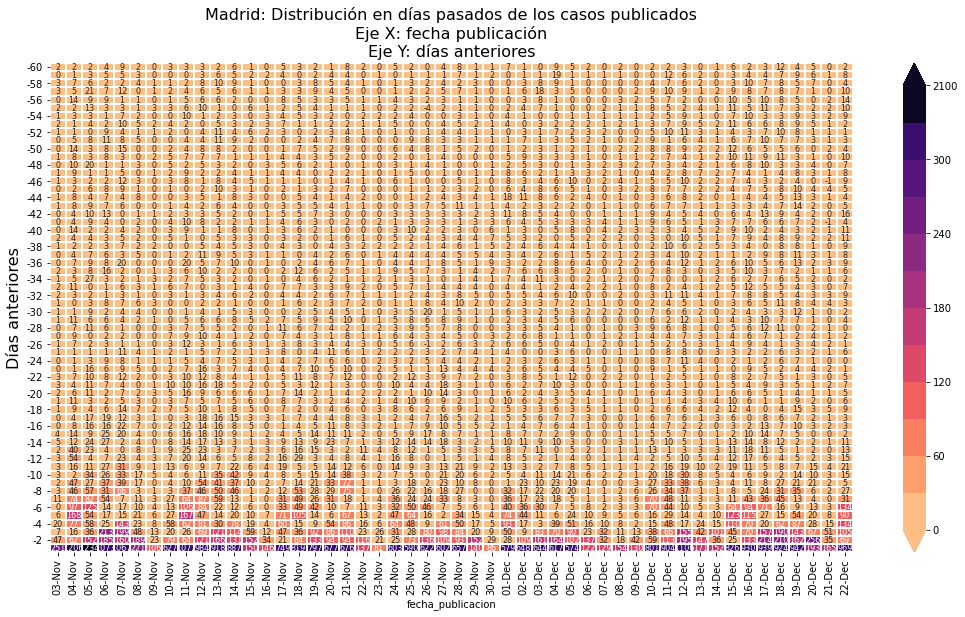

In [32]:
f, ax = plt.subplots(figsize=(18, 9))
sns.heatmap(df1.loc[df1.index[-60:],df1.columns[-50:]], annot=True, cmap=cmap,fmt='0.0f',norm=norm,linewidths=1, 
            ax=ax,annot_kws={"fontsize":8})
ax.set_xticklabels(datetime.strptime(i.get_text()[:10],'%Y-%m-%d').strftime('%d-%b') for i in ax.get_xticklabels())
#ax.set_yticklabels(datetime.strptime(i.get_text()[:10],'%Y-%m-%d').strftime('%d-%b') for i in ax.get_yticklabels())
ax.set_title('Madrid: Distribución en días pasados de los casos publicados\nEje X: fecha publicación\nEje Y: días anteriores',fontsize=16)
ax.set_ylabel('Días anteriores',fontsize=16)
f.savefig('imagenes/distribucion_madrid')

## Variante con porcentuales

In [33]:
df2 = df1.apply(lambda x: x/x.sum()*100,axis=0)

In [34]:
#preparación de la paleta de colores, dando más granularidad a los valores bajos
# 10 rangos entre 0 y 300, y 3 entre 300 y 3000.
rango_valores_1 = np.arange(0,60,1)
#rango_valores_2 = np.arange(300,3000,900)
#rango_valores = np.concatenate([rango_valores_1,rango_valores_2])
colores = sns.color_palette("magma_r",len(rango_valores_1)+1)
cmap, norm = colors.from_levels_and_colors(
    rango_valores_1, 
    colores,extend = 'both')

In [35]:
df2

fecha_publicacion,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28,2020-11-29,2020-11-30,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22
-301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
-300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
-299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
-298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
-297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-5,NaN,19.067635,0.174886,-119.934641,9.668918,21.428571,14.909478,1.068588,0.137363,10.914688,14.387309,10.544713,2.223582,0.156740,12.453125,11.950027,23.890785,2.588235,0.833066,16.220009,16.832362,15.312008,1.819438,0.051881,12.413122,6.465028,3.495798,0.444303,1.040416,10.916715,6.261443,1.858736,0.18750,4.810015,5.210526,3.546512,0.270563,0.303030,6.035562,6.939502,7.001466,0.868878,0.528885,2.376075,2.853067,1.545254,1.183432,6.516680,2.067381,0.724329,0.617030,2.517986,2.469136,2.218570,7.353589,1.964883,

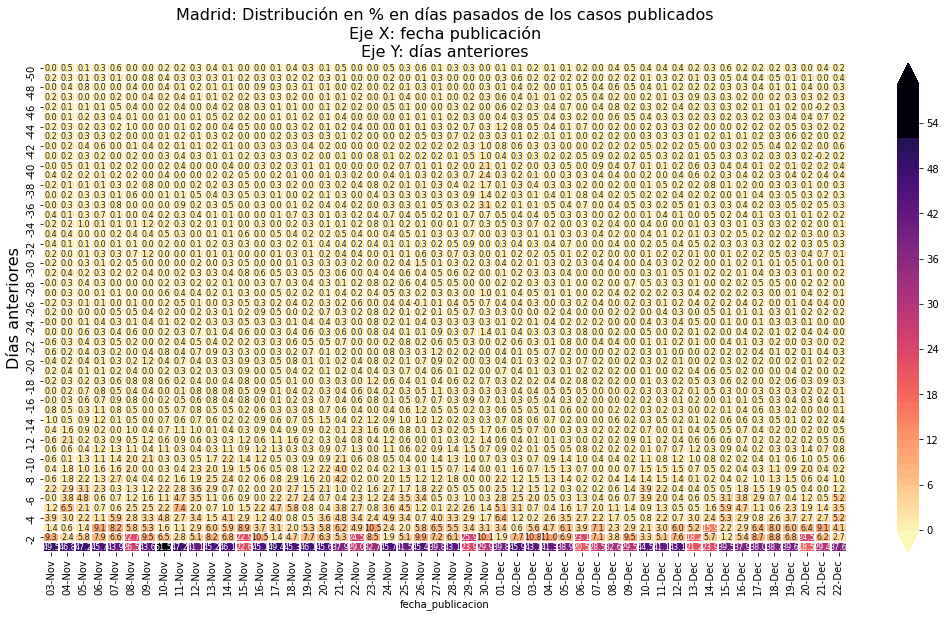

In [36]:
f, ax = plt.subplots(figsize=(18, 9))
sns.heatmap(df2.loc[df2.index[-50:],df2.columns[-50:]], annot=True, cmap=cmap,fmt='0.1f',norm=norm,linewidths=1, 
            ax=ax,annot_kws={"fontsize":8})
ax.set_xticklabels(datetime.strptime(i.get_text()[:10],'%Y-%m-%d').strftime('%d-%b') for i in ax.get_xticklabels())

ax.set_title('Madrid: Distribución en % en días pasados de los casos publicados\nEje X: fecha publicación\nEje Y: días anteriores',fontsize=16)
ax.set_ylabel('Días anteriores',fontsize=16)
f.savefig('imagenes/distribucion_madrid_pct')

In [37]:
acumm=pd.DataFrame()

In [38]:
acumm

""


In [39]:
acumm[1] = df2.apply(lambda x:x[x.index>=-1].sum(),axis=0)
acumm[14] = df2.apply(lambda x:x[x.index>=-14].sum(),axis=0)
acumm[21] = df2.apply(lambda x:x[x.index>=-21].sum(),axis=0)
acumm[100] = df2.apply(lambda x:x[x.index>=-100].sum(),axis=0)
acumm[101] = df2.apply(lambda x:x[x.index<100].sum(),axis=0)
acumm = acumm.drop(datetime(year=2020,month=9,day=4),axis=0)

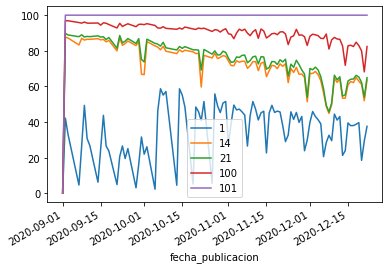

In [40]:
acumm.plot()

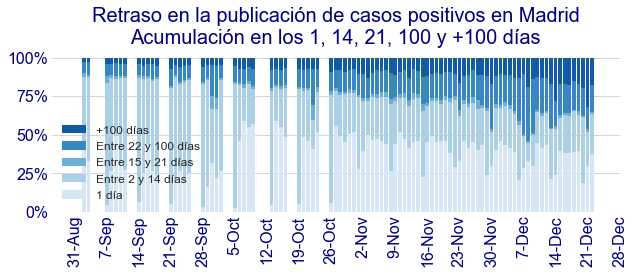

In [41]:
colores = sns.color_palette("Blues_r", 5)

titulo='Retraso en la publicación de casos positivos en Madrid\nAcumulación en los 1, 14, 21, 100 y +100 días'
plt.style.use('seaborn-white')
#f.suptitle(titulo,fontsize=20,x=0.5,y=1,color=color_titulos)
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(1,1,1,)

#ax1.bar(datos['date'].unique(),datos[clave_casos_popu],color='red')
#ax1.bar(pd.to_datetime(acumm.index[:]), acumm[1].values[:],color='navy')

ax1.bar(pd.to_datetime(acumm.index[:]), acumm[101].values[:],color=colores[0],label='+100 días')
ax1.bar(pd.to_datetime(acumm.index[:]),acumm[100].values[:],color=colores[1],label='Entre 22 y 100 días')
ax1.bar(pd.to_datetime(acumm.index[:]), acumm[21].values[:],color=colores[2],label='Entre 15 y 21 días')
ax1.bar(pd.to_datetime(acumm.index[:]), acumm[14].values[:],color=colores[3],label='Entre 2 y 14 días')
ax1.bar(pd.to_datetime(acumm.index[:]), acumm[1].values[:],color=colores[4],label='1 día')

#ax1.set_ylabel(y1,size=18,labelsize = 16, color='navy')
ax1.xaxis.set_tick_params(labelsize=16,labelcolor='navy',rotation=90)
ax1.yaxis.set_tick_params(labelsize=16,labelcolor='navy',width=0)
ax1.set_title(titulo,size=20,color='navy')
#ax1.set_xlim()
#ax.bar(tiempo,valores,label='sin',color=colors,width=.25)


fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = ticker.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(xticks)

XmajorFmt = DateFormatter('%-d-%b')
ax1.xaxis.set_major_formatter(XmajorFmt)
ax1.xaxis.set_major_locator(WeekdayLocator([0]))
ax1.legend(loc=3,framealpha=0,fancybox=True,fontsize='large',facecolor='blue')
#ax1.spines['upper'].set_visible('False')


#ax2.set_ylabel('media móvil 7 días',size=18,color='red')
#ax2.set_yticks([])
ax1.grid(True,axis='y')
#f.text(0.1, 0.1, 'Data Source:{} {}'.format(hashtag_fuente,path_montera34[:-9]), horizontalalignment='left',
#       verticalalignment='center', fontsize=12,color=color_titulos)
#f.text(0.1,0.02,'#python code:{}'.format(github_url),
 #          fontsize=12,horizontalalignment='left',color=color_titulos)
[spine.set_visible(False) for spine in ax1.spines.values()]
f.tight_layout(w_pad=0,h_pad=0,pad=5)

f.savefig('imagenes/casos+distri_madrid.png',dpi=200)

# Distribución desde el punto de vista de la fecha a la que se asignan los casos positivos (idea de David)

In [42]:
df3 = df.copy()

In [43]:
df3 = df3[df3.index>='2020-09-01']

In [44]:
df3.iloc[-5:,-8:]

fecha_publicacion,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22
fecha_asignacion,,,,,,,,
2020-12-17,0.0,0.0,0.0,924.0,162.0,67.0,15.0,90.0
2020-12-18,0.0,0.0,0.0,0.0,942.0,256.0,51.0,134.0
2020-12-19,0.0,0.0,0.0,0.0,0.0,193.0,35.0,105.0
2020-12-20,0.0,0.0,0.0,0.0,0.0,0.0,165.0,69.0
2020-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,969.0


In [45]:
#fecha_inicial = datetime.strptime(df3.columns[0],'%Y-%m-%d')
#fecha_prueba = datetime.strptime(df3.columns[5],'%Y-%m-%d')

In [46]:
df4=pd.DataFrame()
un_dia=dt.timedelta(days=1)
for i,fecha_adj in enumerate(df3.index):
    for j,fecha_pub in enumerate(df3.index):
        try:
            df4.loc[fecha_adj,j] = df3.loc[fecha_adj,
                                           fecha_adj+j*un_dia]
        except:
            df4.loc[fecha_adj,j] = 0

In [47]:
df4.iloc[-5:,-10]

2020-12-17    0.0
2020-12-18    0.0
2020-12-19    0.0
2020-12-20    0.0
2020-12-21    0.0
Name: 102, dtype: float64

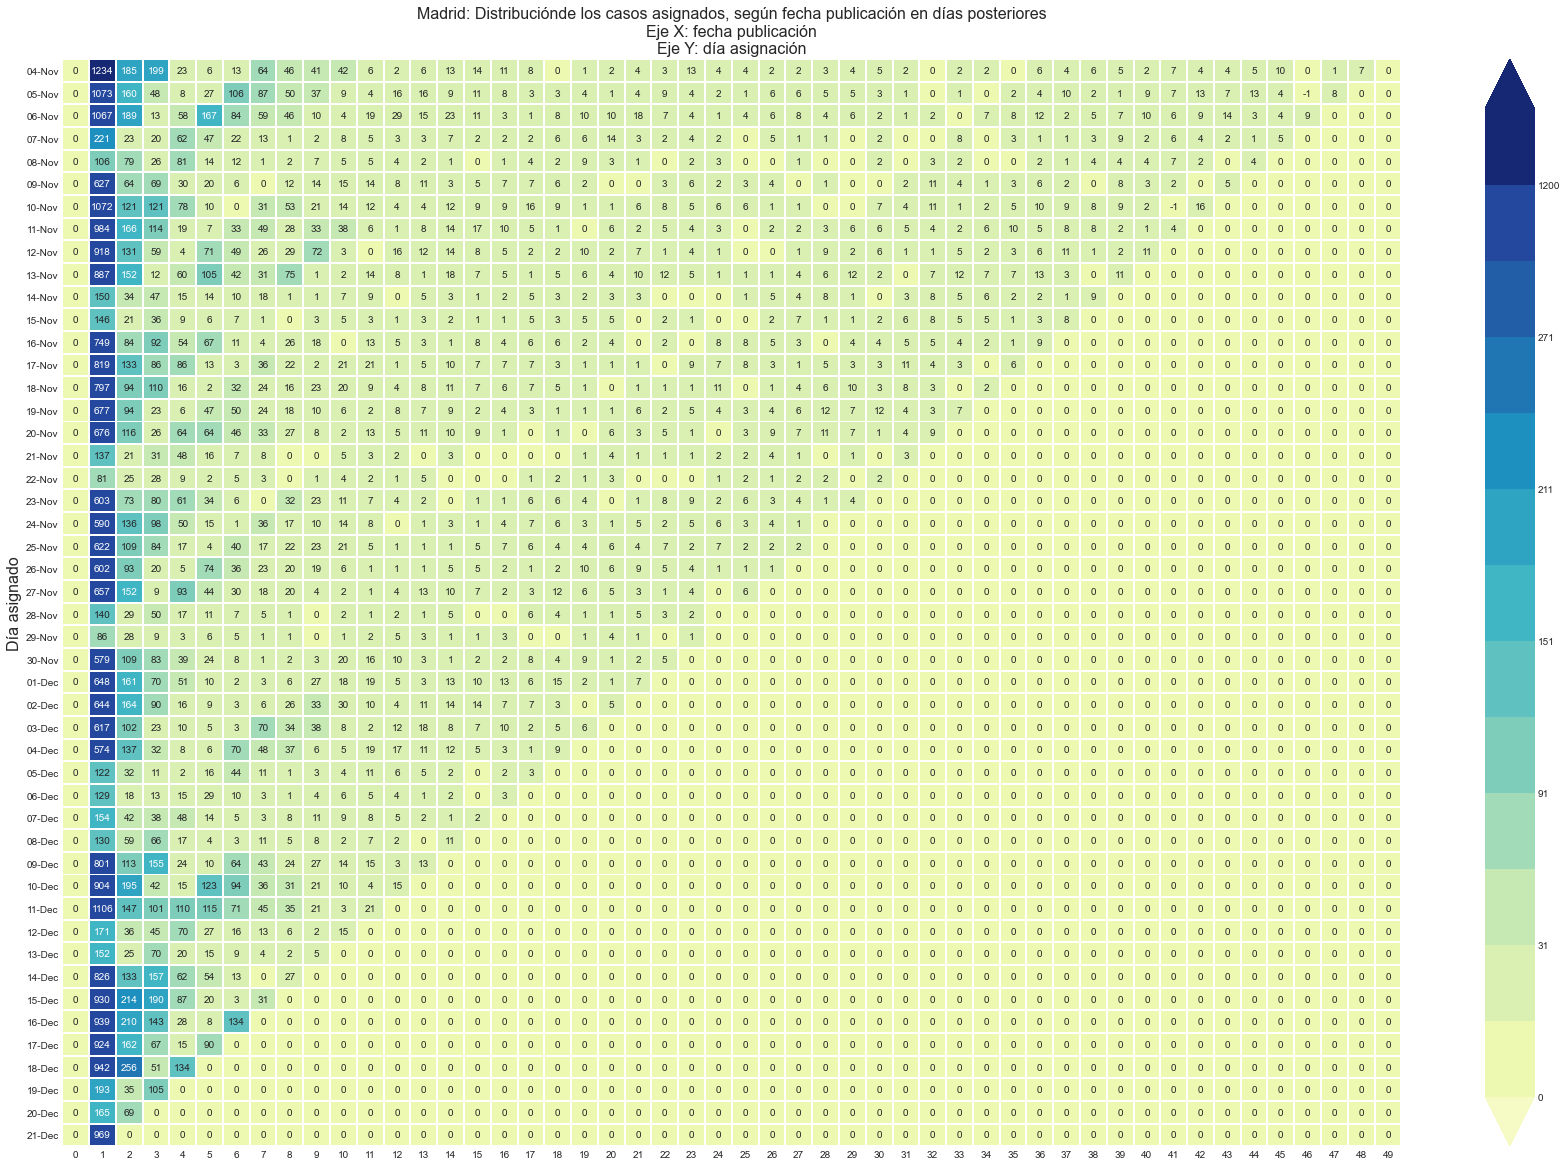

In [48]:
#preparación de la paleta de colores, dando más granularidad a los valores bajos
# 10 rangos entre 0 y 300, y 3 entre 300 y 3000.
rango_valores_0 = np.arange(0,1,1)
rango_valores_1 = np.arange(1,300,30)
rango_valores_2 = np.arange(300,3000,900)
rango_valores = np.concatenate([rango_valores_0,rango_valores_1,rango_valores_2])
colores = sns.color_palette("YlGnBu",len(rango_valores)+1)
cmap, norm = colors.from_levels_and_colors(
    rango_valores, 
    colores,extend = 'both')
f, ax1 = plt.subplots(figsize=(30, 20))
sns.heatmap(df4.loc[df4.index[-48:],df4.columns[:50]], annot=True, cmap=cmap,fmt='0.0f',norm=norm,linewidths=1, 
            ax=ax1,annot_kws={"fontsize":10})
ax1.set_yticklabels(datetime.strptime(i.get_text()[:10],'%Y-%m-%d').strftime('%d-%b') for i in ax1.get_yticklabels())
ax1.set_title('Madrid: Distribuciónde los casos asignados, según fecha publicación en días posteriores\nEje X: fecha publicación\nEje Y: día asignación',fontsize=16)
ax1.set_ylabel('Día asignado',fontsize=16)
f.savefig('imagenes/distribucion_asignados_madrid.png',dpi=144)

## Y ahora en porcentajes

In [49]:
df5 = df4.apply(lambda x: x/x.sum()*100,axis=1)

In [50]:
df5

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111
2020-09-01,NaN,26.266952,25.600761,7.256721,0.000000,0.000000,21.270521,0.475851,0.261718,0.452058,0.404473,0.000000,0.000000,0.999286,0.214133,0.214133,0.309303,0.428266,0.000000,0.000000,0.904116,0.309303,0.237925,0.214133,0.118963,0.000000,0.000000,0.999286,0.118963,1.498929,1.998572,0.285510,0.000000,0.000000,0.666191,0.142755,0.166548,0.190340,0.190340,0.000000,0.000000,0.000000,0.404473,0.142755,0.142755,0.261718,0.000000,0.000000,0.190340,0.095170,0.214133,0.285510,0.095170,0.000000,0.000000,0.142755,0.166548,0.142755,0.118963,0.237925,0.237925,0.047585,0.047585,0.023793,0.166548,0.285510,0.142755,0.142755,0.142755,0.023793,0.071378,0.166548,0.142755,0.095170,0.047585,0.047585,0.023793,0.047585,0.023793,0.166548,0.095170,0.095170,0.023793,0.047585,0.118963,0.118963,0.071378,0.118963,0.118963,0.023793,0.000000,0.095170,0.095170,0.071378,0.071378,0.047585,0.023793,0.071378,0.023793,0.047585,0.095170,0.118963,0.071378,0.000000,0.095170,0.547228,0.237925,0.095170,0.118963,0.166548,0.095170,0.047585
2020-09-02,0.0,24.685205,20.960126,0.000000,0.000000,30.797482,2.990556,0.288562,0.839454,0.367261,0.000000,0.000000,0.813221,0.341028,0.209864,0.288562,0.445960,0.000000,0.000000,0.891920,0.131165,0.209864,0.288562,0.104932,0.000000,0.000000,1.206716,0.131165,1.442812,1.836306,0.341028,0.000000,0.000000,0.367261,0.236097,0.236097,0.367261,0.288562,0.000000,0.000000,0.000000,0.314795,0.183631,0.209864,0.157398,0.000000,0.000000,0.209864,0.078699,0.236097,0.288562,0.157398,0.000000,0.000000,0.341028,0.131165,0.131165,0.157398,0.157398,0.183631,0.000000,0.026233,0.052466,0.104932,0.183631,0.183631,0.209864,0.052466,-0.026233,0.131165,0.052466,0.078699,0.052466,0.104932,0.052466,0.104932,0.052466,0.052466,0.104932,0.131165,0.104932,0.104932,0.052466,0.000000,0.078699,0.000000,0.131165,0.078699,0.052466,0.052466,0.026233,0.052466,0.026233,0.104932,0.078699,0.052466,0.000000,0.052466,0.000000,0.157398,0.104932,0.131165,0.078699,1.285414,0.445960,0.157398,0.183631,0.052466,0.183631,0.052466,0.052466,0.314795
2020-09-03,0.0,30.568846,0.000000,0.000000,28.522063,16.586922,3.934078,1.143009,0.265816,0.000000,0.000000,0.584795,0.239234,0.106326,0.318979,0.451887,0.000000,0.000000,0.691122,0.239234,0.212653,0.212653,0.239234,0.000000,0.000000,0.770867,0.132908,1.408825,1.913876,0.212653,0.000000,0.000000,0.584795,0.106326,0.265816,0.132908,0.292398,0.000000,0.000000,0.000000,0.505051,0.186071,0.159490,0.106326,0.000000,0.000000,0.212653,0.106326,0.292398,0.212653,0.505051,0.000000,0.000000,0.318979,0.106326,0.611377,0.558214,0.132908,0.132908,0.000000,0.026582,0.106326,0.372142,0.212653,0.106326,0.106326,0.000000,0.000000,0.053163,0.079745,0.159490,0.079745,0.318979,0.079745,0.000000,0.079745,0.079745,0.159490,0.053163,0.053163,0.053163,0.000000,0.079745,0.106326,-0.026582,0.053163,0.106326,0.079745,0.000000,0.106326,0.053163,0.000000,0.159490,0.053163,0.000000,0.026582,0.000000,0.000000,0.106326,0.318979,0.212653,0.611377,0.292398,0.106326,0.132908,0.159490,0.212653,0.106326,0.079745,0.026582,0.372142,0.000000
2020-09-04,0.0,0.000000,0.000000,50.398445,8.318756,8.163265,9.640428,4.878523,0.000000,0.000000,3.245870,0.136054,0.291545,0.310982,0.427600,0.000000,0.000000,0.971817,0.116618,0.213800,0.252672,0.194363,0.000000,0.000000,0.583090,0.116618,1.379981,1.690962,0.213800,0.000000,0.000000,0.466472,0.136054,0.233236,0.194363,0.116618,0.000000,0.000000,0.000000,0.408163,0.038873,0.136054,0.136054,0.000000,0.000000,0.330418,0.077745,0.330418,0.116618,0.136054,0.000000,0.000000,0.233236,0.136054,0.116618,0.155491,0.136054,0.116618,0.000000,0.058309,0.038873,0.213800,0.097182,0.077745,0.174927,0.019436,0.01943

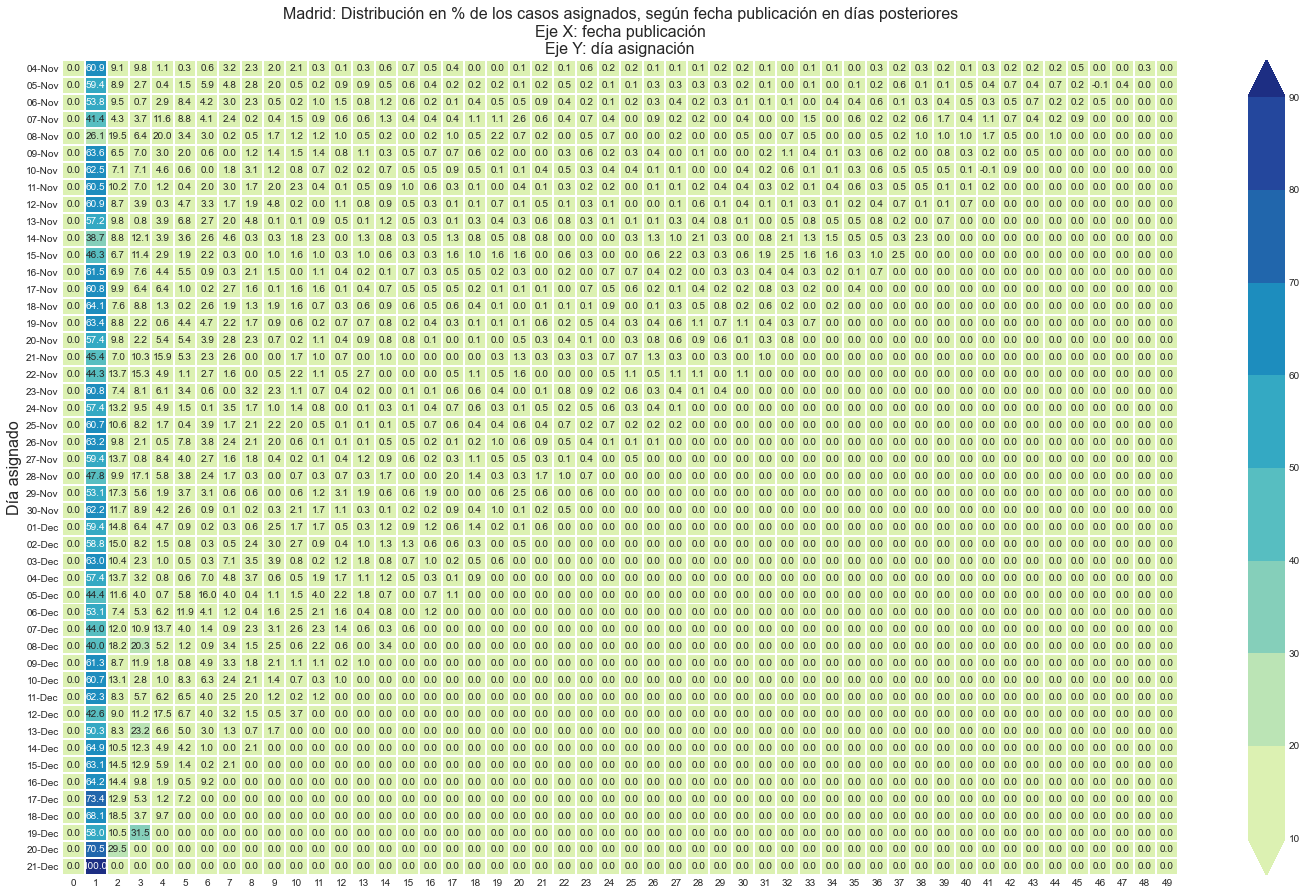

In [61]:
#preparación de la paleta de colores, dando más granularidad a los valores bajos
# 10 rangos entre 0 y 300, y 3 entre 300 y 3000.
rango_valores_1 = np.arange(10,100,10)
rango_valores_0 = np.arange(0,10,1)
rango_valores = np.concatenate([rango_valores_0,rango_valores_1])
colores = sns.color_palette("YlGnBu",len(rango_valores_1)+1)
cmap, norm = colors.from_levels_and_colors(
    rango_valores_1, 
    colores,extend = 'both')
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(df5.loc[df5.index[-48:],df5.columns[:50]], annot=True, cmap=cmap,fmt='0.1f',norm=norm,linewidths=1, 
            ax=ax,annot_kws={"fontsize":10})
ax.set_yticklabels(datetime.strptime(i.get_text()[:10],'%Y-%m-%d').strftime('%d-%b') for i in ax.get_yticklabels())

ax.set_title('Madrid: Distribución en % de los casos asignados, según fecha publicación en días posteriores\nEje X: fecha publicación\nEje Y: día asignación',fontsize=16)
ax.set_ylabel('Día asignado',fontsize=16)
f.savefig('imagenes/distribucion_asignados_pct_madrid_pct')

In [62]:
acumm=pd.DataFrame()
acumm[4] = df5.apply(lambda x:x[x.index<=4].sum(),axis=1)
acumm[7] = df5.apply(lambda x:x[x.index<=7].sum(),axis=1)
acumm[14] = df5.apply(lambda x:x[x.index<=14].sum(),axis=1)
acumm[21] = df5.apply(lambda x:x[x.index<=21].sum(),axis=1)
acumm[22] = df5.apply(lambda x:x.sum(),axis=1)
#acumm = acumm.drop('2020-09-04',axis=0)

In [63]:
acumm

,4,7,14,21,22
2020-09-01,59.124435,80.870807,83.202474,85.367595,100.0
2020-09-02,45.645331,79.721931,82.292760,84.260231,100.0
2020-09-03,59.090909,80.754918,82.270069,84.077618,100.0
2020-09-04,58.717201,81.399417,85.811467,87.560739,100.0
2020-09-05,81.459330,84.988038,88.935407,90.729665,100.0
...,...,...,...,...,...
2020-12-17,92.845787,100.000000,100.000000,100.000000,100.0
2020-12-18,100.000000,100.000000,100.000000,100.000000,100.0
2020-12-19,100.000000,100.000000,100.000000,100.000000,100.0
2020-12-20,100.000000,100.000000,100.000000,100.000000,100.0


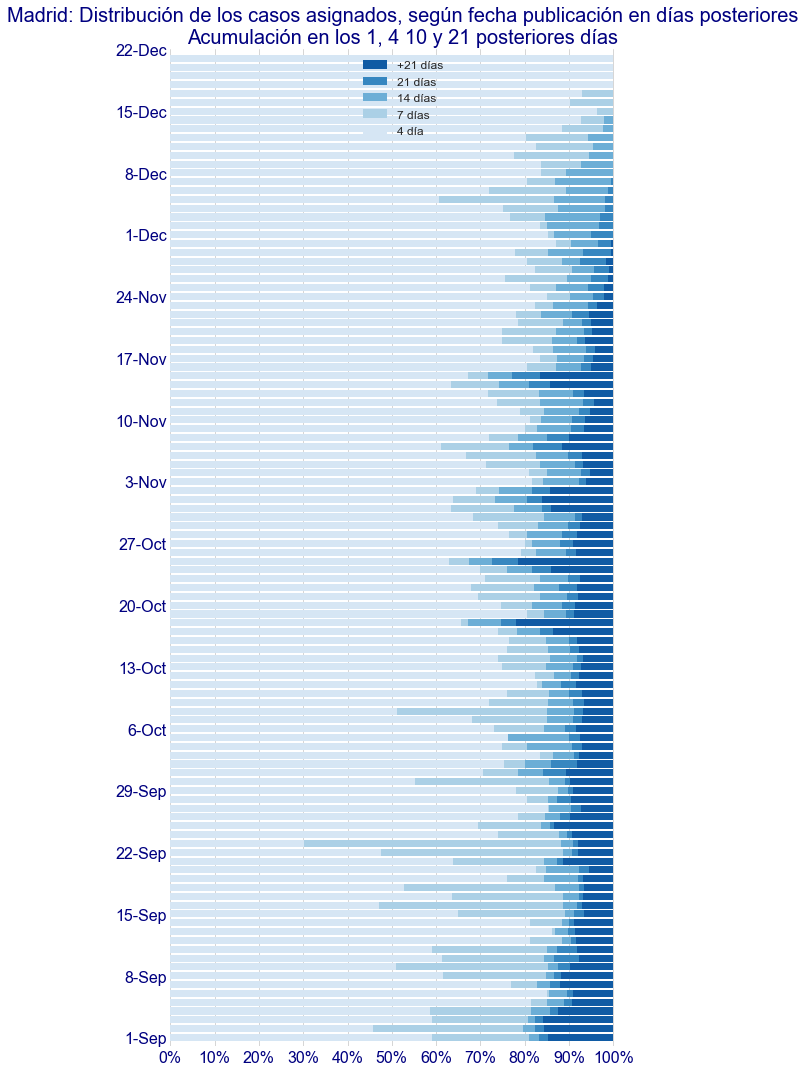

In [64]:
colores = sns.color_palette("Blues_r", 5)

titulo= 'Madrid: Distribución de los casos asignados, según fecha publicación en días posteriores\nAcumulación en los 1, 4 10 y 21 posteriores días'
plt.style.use('seaborn-white')
#f.suptitle(titulo,fontsize=20,x=0.5,y=1,color=color_titulos)
f = plt.figure(figsize=(10,15))
ax1 = f.add_subplot(1,1,1,)

inicio_rango = 0
fin_rango = -1
#ax1.bar(datos['date'].unique(),datos[clave_casos_popu],color='red')
#ax1.bar(pd.to_datetime(acumm.index[:]), acumm[1].values[:],color='navy')

ax1.barh(pd.to_datetime(acumm.index[:]),acumm[22].values[:],color=colores[0],label='+21 días')
ax1.barh(pd.to_datetime(acumm.index[:]),acumm[21].values[:],color=colores[1],label='21 días')
ax1.barh(pd.to_datetime(acumm.index[:]), acumm[14].values[:],color=colores[2],label='14 días')
ax1.barh(pd.to_datetime(acumm.index[:]), acumm[7].values[:],color=colores[3],label='7 días')
ax1.barh(pd.to_datetime(acumm.index[:]), acumm[4].values[:],color=colores[4],label='4 día')

#ax1.set_ylabel(y1,size=18,labelsize = 16, color='navy')
ax1.yaxis.set_tick_params(labelsize=16,labelcolor='navy')
ax1.xaxis.set_tick_params(labelsize=16,labelcolor='navy',width=0)
ax1.set_title(titulo,size=20,color='navy')
ax1.set_xlim()
#ax.bar(tiempo,valores,label='sin',color=colors,width=.25)


fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = ticker.FormatStrFormatter(fmt)
ax1.xaxis.set_major_formatter(xticks)
ax1.set_xticks([0,10,20,30,40,50,60,70,80,90,100])
YmajorFmt = DateFormatter('%-d-%b')
ax1.yaxis.set_major_formatter(YmajorFmt)
ax1.yaxis.set_major_locator(WeekdayLocator([today.weekday()]))

#ax1.yaxis.set_major_locator(mdates.AutoDateLocator())
#ax1.yaxis.set_major_locator(acumm.index[:])
ax1.legend(loc=9,framealpha=0,fancybox=True,fontsize='large',facecolor='blue')
#ax1.spines['upper'].set_visible('False')
ax1.set_ylim(datetime(2020,8,31),today)
#ax1.set_yticks(ax1.get_yticks()[1:-1])
#plt.gca().set_ybound(datetime(2020,9,1),datetime(2020,10,22))
#ax2.set_ylabel('media móvil 7 días',size=18,color='red')
#ax2.set_yticks([])
ax1.grid(True,axis='x')
#f.text(0.1, 0.1, 'Data Source:{} {}'.format(hashtag_fuente,path_montera34[:-9]), horizontalalignment='left',
#       verticalalignment='center', fontsize=12,color=color_titulos)
#f.text(0.1,0.02,'#python code:{}'.format(github_url),
 #          fontsize=12,horizontalalignment='left',color=color_titulos)
[spine.set_visible(False) for spine in ax1.spines.values()]
#f.tight_layout(w_pad=0,h_pad=10,pad=5)

#ax1.set_title(titulo,size=20,color='navy')
#f.subplots_adjust(bottom=.1,top=.9)
f.tight_layout()
f.savefig('imagenes/resumen_asignados_madrid.png',dpi=200)

In [65]:
acumm.loc[acumm.index[:-21],4].mean()

71.96229936298758

In [66]:
acumm.loc[acumm.index[:-21],7].mean()

83.6301561634658

In [67]:
acumm.loc[acumm.index[:-21],14].mean()

88.9814508428118

In [68]:
acumm.loc[acumm.index[:-21],21].mean()

91.61664001042924

In [69]:
acumm

,4,7,14,21,22
2020-09-01,59.124435,80.870807,83.202474,85.367595,100.0
2020-09-02,45.645331,79.721931,82.292760,84.260231,100.0
2020-09-03,59.090909,80.754918,82.270069,84.077618,100.0
2020-09-04,58.717201,81.399417,85.811467,87.560739,100.0
2020-09-05,81.459330,84.988038,88.935407,90.729665,100.0
...,...,...,...,...,...
2020-12-17,92.845787,100.000000,100.000000,100.000000,100.0
2020-12-18,100.000000,100.000000,100.000000,100.000000,100.0
2020-12-19,100.000000,100.000000,100.000000,100.000000,100.0
2020-12-20,100.000000,100.000000,100.000000,100.000000,100.0


In [70]:
acumm.loc[acumm.index[:-21],]

,4,7,14,21,22
2020-09-01,59.124435,80.870807,83.202474,85.367595,100.0
2020-09-02,45.645331,79.721931,82.292760,84.260231,100.0
2020-09-03,59.090909,80.754918,82.270069,84.077618,100.0
2020-09-04,58.717201,81.399417,85.811467,87.560739,100.0
2020-09-05,81.459330,84.988038,88.935407,90.729665,100.0
...,...,...,...,...,...
2020-11-26,75.550892,89.506821,95.068206,98.740818,100.0
2020-11-27,82.368897,90.687161,95.569620,99.005425,100.0
2020-11-28,80.546075,88.395904,92.491468,98.293515,100.0
2020-11-29,77.777778,85.185185,93.209877,99.382716,100.0
